# MICCAI Educational Challenge (MEC) 2019
Deep learning [1] has been widely used in many medical imaging applications, including time-since-stroke classification [2], and tissue outcome prediction [3]. However, these models are often criticized as "black-boxes", in which the mechanism of predictions are hardly understood and therefore limit the adaptation of these models in real clinical applications. 

In this tutorial, there are three objectives: (1) we illustrate an end-to-end workflow of training a deep learning segmentation model (Unet) ; (2) we illustrate several implementations of deep learning visualization techniques to interpret the classification; (3) we demonstrate how to achieve objectives 1&2 using pytorch (https://pytorch.org/) and an open-source imaging library medicaltorch (https://github.com/perone/medicaltorch). 

There are two notebooks in this tutorial, which correspond to the two parts: segmentation model training and deep learning visualization.

References
- [1] LeCun, Yann, Yoshua Bengio, and Geoffrey Hinton. "Deep learning." nature 521.7553 (2015): 436.
- [2] Ho, King Chung, et al. "A Machine Learning Approach for Classifying Ischemic Stroke Onset Time from Imaging." IEEE transactions on medical imaging (2019).
- [3] Ho, King Chung, et al. "Predicting ischemic stroke tissue fate using a deep convolutional neural network on source magnetic resonance perfusion images." Journal of Medical Imaging 6.2 (2019): 026001.

## Notebook Running Environment
- The notebooks have been fully tested using Google Colab (https://colab.research.google.com/notebooks/welcome.ipynb#recent=true), which is a platform that provides free CPU and GPU computational resources. If you have a good GPU and a good CPU, you can run these two notebooks in your local environment. Here are two decent colab tutorials to begin with: 
  - Overview: https://www.geeksforgeeks.org/how-to-use-google-colab/
  - How to use GPU in colab: https://hackernoon.com/begin-your-deep-learning-project-for-free-free-gpu-processing-free-storage-free-easy-upload-b4dba18abebc
- Major Packages needed:
  - Numpy v1.16.4
  - Pytorch v1.1.0
  - MedicalTorch v0.2
  - Pandas v0.24.2
  - Matplotlib v3.0.3
  - Torchvision v0.3.0
  - MacOS 10.14.3 (OS environment)
- Note: We observed that colab may not run properly in Windows 10. We suggest using it in a Linux environment.

# Part 1: Deep Learning Unet Model Training for Spinal Cord Segmentation
### By King Chung Ho *, Ratna Sagari Grandhi *, William Speier, Corey Arnold, University of California, Los Angeles, CA, USA
*These authors contributed equally to this work


# Data: Spinal Cord Segmentation Challenge 
- The data comes from the spinal cord grey matter segmentation challenge [1]. Please download the spinal cord data to a designated local environment folder or onto google drive (if you are using Google Colab) through the niftyweb: http://niftyweb.cs.ucl.ac.uk/challenge/index.php#citation
  
- Briefly, the challenge is to develop methods for better white matter (WM) and grey matter (GM) segmentation in the cervical cord cross-sectional area. The data comes from 4 sites, in which each site provides 20 heavy subject images, gray matter (GM) & white matter (WM) manual segmentations. 10 subject images (from each site) are used for training and the remaining 10 subject images (from each site) are used for testing.

References
- [1] Prados, Ferran, et al. "Spinal cord grey matter segmentation challenge." Neuroimage 152 (2017): 312-329.






# Setup Colab
You can skip this section if you are running the notebook in your local environment. 

## Mount a google drive folder
-  For more reference on how to mount a good drive folder please visit: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# checking if mount is successful, i.e. we are able to see the data folder
!ls "/content/drive/My Drive/MICCAI-MEC-2019"

'2017 Spinal cord grey matter segmentation challenge.pdf'   mec
 data							    trained_models


In [0]:
# check RAM, CPU, and GPU
!free -h
!df -BG
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:            12G        720M        9.0G        900K        3.1G         11G
Swap:            0B          0B          0B
Filesystem     1G-blocks  Used Available Use% Mounted on
overlay             359G   32G      309G  10% /
tmpfs                 1G    0G        1G   0% /dev
tmpfs                 7G    0G        7G   0% /sys/fs/cgroup
/dev/sda1           365G   43G      323G  12% /opt/bin
tmpfs                 7G    1G        7G   1% /var/colab
shm                   6G    1G        6G   1% /dev/shm
tmpfs                 7G    0G        7G   0% /proc/acpi
tmpfs                 7G    0G        7G   0% /proc/scsi
tmpfs                 7G    0G        7G   0% /sys/firmware
drive               359G   66G      293G  19% /content/drive
Sat Aug 24 21:29:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Versi

# Install Necessary Packages

In [0]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
!pip install medicaltorch
!pip3 install numpy
!pip3 install pandas

Looking in links: https://download.pytorch.org/whl/torch_stable.html


# Data Exploration
- Get familiar with the medicaltorch library and explore the spinal cord dataset. This tutorial is modified heavily from this example notebook: https://colab.research.google.com/drive/1V516_8lzebSPw_ygZhJQLfbGedMDikPc#scrollTo=yD3mbIc8tzed


In [0]:
from collections import defaultdict
from tqdm import tqdm
from medicaltorch import datasets as mt_datasets
from medicaltorch import models as mt_models
from medicaltorch import transforms as mt_transforms
from medicaltorch import losses as mt_losses
from medicaltorch import metrics as mt_metrics
from medicaltorch import filters as mt_filters
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim

import torch.backends.cudnn as cudnn
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt


torch.manual_seed(1)
np.random.seed(1)
cudnn.benchmark = True
%matplotlib inline

In [0]:
# Define where the data is stored. Please change this part according to where you
# store your data. The example path here assumes your data is stored in Google Drive
# and you are using Google Colab to run the notebook

root_dir = 'drive/My Drive/MICCAI-MEC-2019'
data_train_dir = '%s/data/gm-sc-challenge2017-train' %root_dir
data_test_dir = '%s/data/gm-sc-challenge2017-test' %root_dir

The pair of images dimension is: ((100, 100, 3), (100, 100, 3))
An input image dimension is: (100, 100)
The number of unique labels in the mask: [0. 1. 2.]


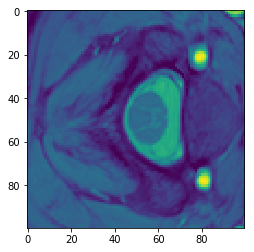

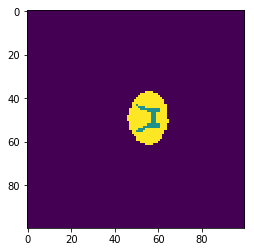

In [0]:
# an example image and its ground truth mask
mri_input_filename = '%s/%s' %(data_train_dir,'site1-sc01-image.nii.gz')
mri_gt_filename = '%s/%s' %(data_train_dir, 'site1-sc01-mask-r1.nii.gz')

# load the data and pairing two imaging types, e.g., the input image and the 
# ground truth mask
pairs = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)
print('The pair of images dimension is:', pairs.get_pair_shapes())

# Get the first input image slice and the first ground truth mask slice
# An input image dimension is 100 x 100, and there are three slices.
# The label=0 represents background, the label=1 represents GM, and the label=2
# represents WM
pair = pairs.get_pair_slice(0)
img_input = pair["input"]
img_gt = pair["gt"]
print('An input image dimension is:', img_input.shape)
print('The number of unique labels in the mask:', np.unique(img_gt))

# show the image
plt.imshow(img_input)
plt.show()

# show the ground truth (gt)
plt.imshow(img_gt)
plt.show()

## Example of using Pytorch Dataset module with MedicalTorch
- MedicalTorch has a specific class called 'SCGMChallenge2DTrain', which inherits from the 'MRI2DSegmentationDataset' class, which in turn inherits from the pytorch 'Dataset' class.
- Note that using the class 'SCGMChallenge2DTrain' will automatically limit the class label to be 0 and 1. Therefore, in the following training, we combine both GM and WM segmentation tasks, i.e., we are training a Unet to classify whether it is a GM/WM in a voxel. This fits in well with our visualization tutorial because this will simplify the visual interpretation of the trained model.

torch.Size([1, 200, 200])


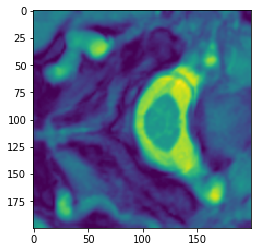

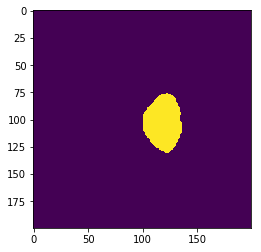

In [0]:
# create a dataset 
composed_transform = transforms.Compose([
            mt_transforms.Resample(0.25, 0.25), 
            mt_transforms.CenterCrop2D((200, 200)), 
            mt_transforms.ToTensor(),
])

# load all the data
train_dataset = mt_datasets.SCGMChallenge2DTrain(root_dir=data_train_dir, transform=composed_transform)
print(train_dataset[0]['input'].shape)

# show the image
plt.imshow(train_dataset[50]['input'].squeeze())
plt.show()

# show the ground truth 
plt.imshow(train_dataset[50]['gt'].squeeze())
plt.show()

In [0]:
# create a dataloader which can generate mini batches
dataloader = DataLoader(train_dataset, batch_size=10,
                        shuffle=True, num_workers=4,
                        collate_fn=mt_datasets.mt_collate)
minibatch = next(iter(dataloader))

# check minibatch size
minibatch['input'].size()

torch.Size([10, 1, 200, 200])

# Training a UNet Segmentation Model for GM and WM

## Train and validation dataset preparation

In [0]:
# define the train and validation transformers
train_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ElasticTransform(alpha_range=(28.0, 30.0),
                                       sigma_range=(3.5, 4.0),
                                       p=0.3),
        mt_transforms.RandomAffine(degrees=4.6,
                                   scale=(0.98, 1.02),
                                   translate=(0.03, 0.03)),
        mt_transforms.RandomTensorChannelShift((-0.10, 0.10)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

val_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

In [0]:
# define the pytorch datasets
train_dataset = mt_datasets.SCGMChallenge2DTrain(root_dir=data_train_dir,
                                                 subj_ids=range(1, 9),
                                                 transform=train_transform,
                                                 slice_filter_fn=mt_filters.SliceFilter())

val_dataset = mt_datasets.SCGMChallenge2DTrain(root_dir=data_train_dir,
                                                 subj_ids=range(9, 11),
                                                 transform=val_transform)

# define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=10,
                          shuffle=True, pin_memory=True,
                          collate_fn=mt_datasets.mt_collate,
                          num_workers=1)

val_loader = DataLoader(val_dataset, batch_size=10,
                        shuffle=True, pin_memory=True,
                        collate_fn=mt_datasets.mt_collate,
                        num_workers=1)

## Train a model
- We will train a well-known segmentation model, U-net, for GM segmentation. This model is not the state-of-the-art model for segmentation. However, it serves the purpose of our tutorial, in which we need a model that is decent for visualization.
- The U-net paper: "Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015".

In [0]:
# define the threshold predictions, when the value is greater than a threshold,
# it is classified as 1, else 0
def threshold_predictions(predictions, thr=0.999):
    """
    Define the prediction mask.
    
    :param predictions (torch tensor or numpy): the prediction matrix
    :param thr (float): the value to classify as 1
    """
    thresholded_preds = predictions[:]
    low_values_indices = thresholded_preds < thr
    thresholded_preds[low_values_indices] = 0
    low_values_indices = thresholded_preds >= thr
    thresholded_preds[low_values_indices] = 1
    return thresholded_preds

def accuracy(prediction, groundtruth):
    """
    Calculate the accuracy.
    
    :param predictions (torch tensor or numpy): the prediction matrix
    :param groundtruth (torch tensor or numpy): the ground truth matrix
    """
    FP = np.float(np.sum((prediction == 1) & (groundtruth == 0)))
    FN = np.float(np.sum((prediction == 0) & (groundtruth == 1)))
    TP = np.float(np.sum((prediction == 1) & (groundtruth == 1)))
    TN = np.float(np.sum((prediction == 0) & (groundtruth == 0)))
    N = FP + FN + TP + TN
    return np.divide(TP + TN, N) * 100.0

# evaluation metric
metric_fns = [mt_metrics.dice_score,
              mt_metrics.hausdorff_score,
              mt_metrics.precision_score,
              mt_metrics.recall_score,
              mt_metrics.specificity_score,
              mt_metrics.intersection_over_union,
              mt_metrics.accuracy_score]
metric_mgr = mt_metrics.MetricManager(metric_fns)

In [0]:
# show image function
def show_img(img):
  """
  Show images using pytorch make_grid
  
  :param img: a pytorch tensor with a size of num_samples x num_channels x width x height
  """
  img = vutils.make_grid(img, normalize=True, scale_each=True)
  plt.figure()
  plt.imshow(img.permute(1, 2, 0))

In [0]:
# model
model = mt_models.Unet(drop_rate=0.4, bn_momentum=0.1)
model.cuda()

# train hyperparameters
# we will use the Adam optimizer to optimize the hyperparameter training
num_epochs = 10
initial_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1412: RuntimeWarning: invalid value encountered in double_scalars
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))
 10%|█         | 1/10 [01:08<10:17, 68.56s/it]

==================== Epoch 1 ====================

Train loss: -0.6123
Validation. Loss: -0.9080, Accuracy: 99.4879, Dice: 75.3689
Time in this epoch: 68.56075668334961


 20%|██        | 2/10 [02:09<08:50, 66.30s/it]

==================== Epoch 2 ====================

Train loss: -0.8715
Validation. Loss: -0.9098, Accuracy: 99.4883, Dice: 76.4690
Time in this epoch: 61.00858807563782


 30%|███       | 3/10 [03:12<07:36, 65.15s/it]

==================== Epoch 3 ====================

Train loss: -0.9007
Validation. Loss: -0.9274, Accuracy: 99.5802, Dice: 77.6230
Time in this epoch: 62.49079418182373


 40%|████      | 4/10 [04:14<06:26, 64.35s/it]

==================== Epoch 4 ====================

Train loss: -0.9157
Validation. Loss: -0.9238, Accuracy: 99.5800, Dice: 77.7828
Time in this epoch: 62.46209406852722


 50%|█████     | 5/10 [05:17<05:18, 63.80s/it]

==================== Epoch 5 ====================

Train loss: -0.9235
Validation. Loss: -0.9250, Accuracy: 99.5719, Dice: 77.8067
Time in this epoch: 62.519925594329834


 60%|██████    | 6/10 [06:20<04:14, 63.56s/it]

==================== Epoch 6 ====================

Train loss: -0.9298
Validation. Loss: -0.9245, Accuracy: 99.5836, Dice: 77.9288
Time in this epoch: 62.99565672874451


 70%|███████   | 7/10 [07:22<03:09, 63.28s/it]

==================== Epoch 7 ====================

Train loss: -0.9332
Validation. Loss: -0.9249, Accuracy: 99.5830, Dice: 78.1215
Time in this epoch: 62.628671407699585


 80%|████████  | 8/10 [08:25<02:06, 63.10s/it]

==================== Epoch 8 ====================

Train loss: -0.9362
Validation. Loss: -0.9270, Accuracy: 99.5936, Dice: 78.1693
Time in this epoch: 62.664997577667236


 90%|█████████ | 9/10 [09:28<01:02, 62.97s/it]

==================== Epoch 9 ====================

Train loss: -0.9378
Validation. Loss: -0.9291, Accuracy: 99.5963, Dice: 78.2319
Time in this epoch: 62.68432664871216


100%|██████████| 10/10 [10:30<00:00, 62.90s/it]

==================== Epoch 10 ====================

Train loss: -0.9379
Validation. Loss: -0.9306, Accuracy: 99.5974, Dice: 78.2451
Time in this epoch: 62.73518252372742

An example of input images, ground truth masks, and the prediction masks in the last batch:


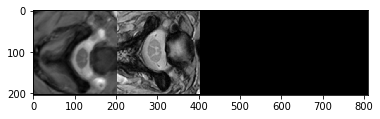

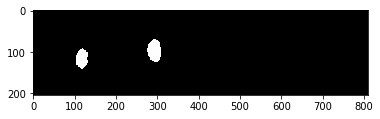

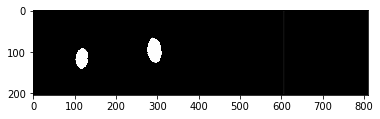

In [0]:
for epoch in tqdm(range(1, num_epochs+1)):
    start_time = time.time()   
    metric_mgr.reset()
  
    # ==================== Training ====================
    # train parameters setting
    model.train()     
    
    # loss and metrics calculation
    train_loss = 0.0
    num_steps = 0
    for i, batch in enumerate(train_loader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        # convert to cuda
        var_input = input_samples.cuda()
        var_gt = gt_samples.cuda(async=True)

        # forward pass
        preds = model(var_input)
        loss = mt_losses.dice_loss(preds, var_gt)
        train_loss += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_steps += 1
    train_loss = train_loss / num_steps
 
    # ==================== Evaluation ====================
    model.eval()
    val_loss = 0.0
    num_steps = 0
    for i, batch in enumerate(val_loader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        # calculate loss
        with torch.no_grad():
            # convert to cuda
            a_input = input_samples.cuda()
            a_gt = gt_samples.cuda(async=True)
            
            # forward pass
            preds = model(a_input)
            loss = mt_losses.dice_loss(preds, a_gt)
            val_loss += loss.item()

        # evaluation metrics computation
        gt_npy = gt_samples.numpy().astype(np.uint8).squeeze(axis=1)
        preds_npy = threshold_predictions(preds.data.cpu().numpy()).astype(np.uint8).squeeze(axis=1)
        metric_mgr(preds_npy, gt_npy)

        # update
        num_steps += 1
    val_loss = val_loss / num_steps

    # evaluation metrics
    metrics_dict = metric_mgr.get_results()
    
    # print
    print('==================== Epoch %s ====================' %epoch)
    print('\nTrain loss: {:.4f}'.format(train_loss))
    print('Validation. Loss: {:.4f}, Accuracy: {:.4f}, Dice: {:.4f}'.format(val_loss, 
                                                                 metrics_dict["accuracy_score"],
                                                                 metrics_dict['dice_score']          
                                                                           ))
    print('Time in this epoch: %s' %(time.time() - start_time))
    
    # update
    scheduler.step()

# visual inspection for the last batch in the validation
print()
print('An example of input images, ground truth masks, and the prediction masks in the last batch:')
show_img(input_samples)
show_img(gt_samples)
show_img(preds.data.cpu())

### The size of the input image and the output mask

In [0]:
# num_of_images x num_channels x width x height
input_samples.shape

torch.Size([4, 1, 200, 200])

In [0]:
# num_of_images x width x height
preds.shape

torch.Size([4, 1, 200, 200])

In [0]:
# two types of labels: 0 and 1
var_gt.cpu().unique()

tensor([0., 1.])

## Save the model
- For details, please visit: https://pytorch.org/tutorials/beginner/saving_loading_models.html#what-is-a-state-dict

In [0]:
import datetime

In [0]:
timestamp = datetime.datetime.now().strftime("%I_%M%p-%B-%d-%Y")
print(timestamp)

09_41PM-August-24-2019


In [0]:
save_dir = '%s/trained_models/unet_%s.pt' %(root_dir, timestamp)
torch.save(model.state_dict(), save_dir)
print(save_dir)

drive/My Drive/MICCAI-MEC-2019/trained_models/unet_09_41PM-August-24-2019.pt


### Check if the model is saved appropriately

In [0]:
# check the trained model's first convolutional layer weight
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.data.shape)
        print(param.data[0])
        break

conv1.conv1.weight
torch.Size([64, 1, 3, 3])
tensor([[[-0.1910, -0.3071, -0.2428],
         [ 0.2693,  0.2706,  0.0847],
         [ 0.0031,  0.3063,  0.2006]]], device='cuda:0')


In [0]:
# create a dummy unet model
model_load = mt_models.Unet(drop_rate=0.4, bn_momentum=0.1)
for name, param in model_load.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.data.shape)
        print(param.data[0])
        break

conv1.conv1.weight
torch.Size([64, 1, 3, 3])
tensor([[[-0.2522, -0.1127, -0.2979],
         [-0.0372, -0.1384,  0.0896],
         [-0.0457,  0.2120, -0.2840]]])


In [0]:
# load the saved model weights and you can see that the weights
# are the same as the trained model weights. 
model_load.load_state_dict(torch.load(save_dir))
for name, param in model_load.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.data.shape)
        print(param.data[0])
        break

conv1.conv1.weight
torch.Size([64, 1, 3, 3])
tensor([[[-0.1910, -0.3071, -0.2428],
         [ 0.2693,  0.2706,  0.0847],
         [ 0.0031,  0.3063,  0.2006]]])
